In [1]:
%pip install ccxt yfinance seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import ccxt
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from utils import (
    TRAIN_TARGETS_PARQUET_FILE_PATH,
    OHLCV_FILE_PATH,
    TRAIN_START_DATE,
    CURRENT_DATE,
    SAMPLE_SYMBOLS,
    human_readable_format
)

TRAIN_START_DATE updated to: 2020-06-01, TRAIN_END_DATE updated to: 2024-07-03


In [3]:
train_df = pd.read_parquet(TRAIN_TARGETS_PARQUET_FILE_PATH)

In [4]:
# Initialize the ccxt binance client
exchange = ccxt.binance()

# Fetch historical data from Binance
def fetch_historical_data_binance(symbol, start_date, end_date):
    try:
        since = exchange.parse8601(start_date + 'T00:00:00Z')
        
        # Fetch daily OHLCV data
        ohlcv = exchange.fetch_ohlcv(symbol, '1d', since)
        
        # Convert to DataFrame
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
        return df[['date', 'open', 'high', 'low', 'close', 'volume']]
    except Exception as e:
        #print(f"Error fetching data for {symbol} from {start_date} to {end_date}: {e}")
        return None

# Fetch historical data from Yahoo Finance
def fetch_historical_data_yahoo(symbol, start_date, end_date):
    try:
        ticker = yf.Ticker(symbol)
        historical_data = ticker.history(start=start_date, end=end_date)
        
        historical_data.reset_index(inplace=True)
        historical_data['date'] = historical_data['Date'].dt.date
        return historical_data[['date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        })
    except Exception as e:
        print(f"Yahoo: Error fetching data for {symbol} from {start_date} to {end_date}: {e}")
        return None

ohlcv_historical_data = pd.DataFrame()
if os.path.exists(OHLCV_FILE_PATH):
    print(f"The OHLCV data is available localy. Reading the file: {OHLCV_FILE_PATH}")
    ohlcv_historical_data = pd.read_csv(OHLCV_FILE_PATH)
else: 
    print(f'Fetching online ohlcv data from {TRAIN_START_DATE} till {CURRENT_DATE}')

    # Fetch data for all symbols
    for symbol in train_df['symbol'].unique():
        symbol_binance = symbol + '/USDT'
        symbol_yahoo = symbol + '-USD'
        
        # Try fetching historical data from Binance
        historical_data = fetch_historical_data_binance(symbol_binance, TRAIN_START_DATE, CURRENT_DATE)
        
        # If Binance data is not available, use Yahoo Finance as fallback
        if historical_data is None:
            print(f'Data for {symbol} is not available on binance, downloading the info from yfinance. ')
            historical_data = fetch_historical_data_yahoo(symbol_yahoo, TRAIN_START_DATE, CURRENT_DATE)
        
        # Add the symbol to the data
        if historical_data is not None and not historical_data.empty:
            historical_data['symbol'] = symbol
            ohlcv_historical_data = pd.concat([ohlcv_historical_data, historical_data])

    print(f'Done! All the ohlcv data has been downloaded!')

ohlcv_historical_data.head()

The OHLCV data is available localy. Reading the file: ../data/ohlcv_historical_data.csv


,symbol,date,open,high,low,close,volume
0,0xBTC,2020-06-01,0.142721,0.152836,0.133416,0.145287,1227624
1,0xBTC,2020-06-02,0.145457,0.153313,0.129571,0.134045,1096847
2,0xBTC,2020-06-03,0.134045,0.153145,0.126926,0.140528,1139340
3,0xBTC,2020-06-04,0.140615,0.144362,0.123043,0.130178,1164467
4,0xBTC,2020-06-05,0.130178,0.134866,0.125276,0.126849,1127147


# Clean-up the ohlcv data

In [5]:
# Drop rows with missing values in 'open', 'high', and 'low'
olhcv_cleaned_data = ohlcv_historical_data.dropna(subset=['open', 'high', 'low', 'close'])

# Remove rows where 'open', 'high', 'low', or 'close' are zero
olhcv_cleaned_data = olhcv_cleaned_data[(olhcv_cleaned_data['open'] > 0) & 
                            (olhcv_cleaned_data['high'] > 0) & 
                            (olhcv_cleaned_data['low'] > 0) & 
                            (olhcv_cleaned_data['close'] > 0)]

# Remove rows where 'volume' is zero (optional based on context)
olhcv_cleaned_data = olhcv_cleaned_data[olhcv_cleaned_data['volume'] > 0]
olhcv_cleaned_data['date'] = pd.to_datetime(olhcv_cleaned_data['date'])

# Reorder columns to move 'symbol' to the first position
columns_order = ['symbol'] + [col for col in olhcv_cleaned_data.columns if col != 'symbol']
olhcv_cleaned_data = olhcv_cleaned_data[columns_order]

# Save the ohlcs data to a CSV file
olhcv_cleaned_data.to_csv(OHLCV_FILE_PATH, index=False)

# Verify the data cleaning process
olhcv_cleaned_data.head()


,symbol,date,open,high,low,close,volume
0,0xBTC,2020-06-01,0.142721,0.152836,0.133416,0.145287,1227624
1,0xBTC,2020-06-02,0.145457,0.153313,0.129571,0.134045,1096847
2,0xBTC,2020-06-03,0.134045,0.153145,0.126926,0.140528,1139340
3,0xBTC,2020-06-04,0.140615,0.144362,0.123043,0.130178,1164467
4,0xBTC,2020-06-05,0.130178,0.134866,0.125276,0.126849,1127147


# EDA

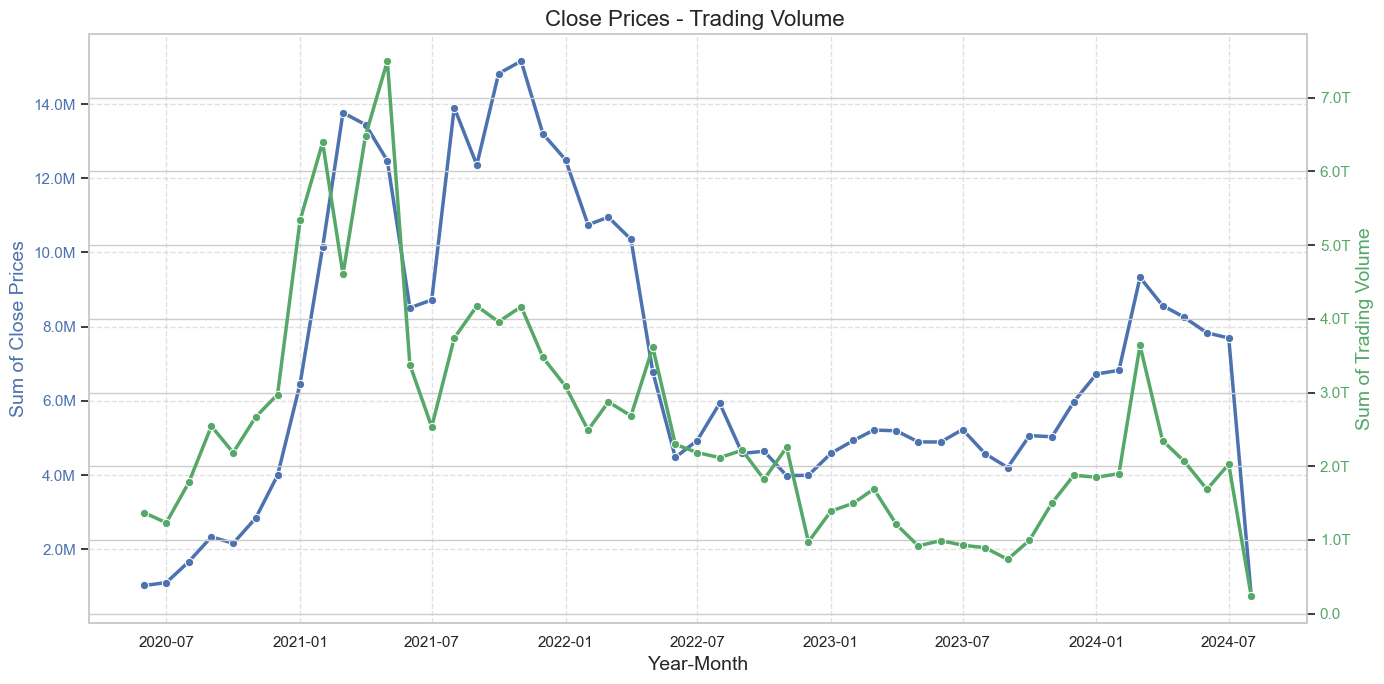

In [8]:
# Load the data
data = pd.read_csv(OHLCV_FILE_PATH)

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract the year and month from the 'date' column
data['year_month'] = data['date'].dt.to_period('M')

# Group by the 'year_month' and sum the 'close' prices and 'volume'
monthly_data_sum = data.groupby('year_month').agg({
    'close': 'sum',
    'volume': 'sum'
}).reset_index()

# Convert 'year_month' back to datetime for plotting
monthly_data_sum['year_month'] = monthly_data_sum['year_month'].dt.to_timestamp()

# Set up the plot style and size
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the close prices on the left y-axis
sns.lineplot(x='year_month', y='close', data=monthly_data_sum, marker='o', color='b', linewidth=2.5, ax=ax1)
ax1.set_xlabel('Year-Month', fontsize=14)
ax1.set_ylabel('Sum of Close Prices', fontsize=14, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter

# Creating a second y-axis for the trading volume
ax2 = ax1.twinx()
sns.lineplot(x='year_month', y='volume', data=monthly_data_sum, marker='o', color='g', linewidth=2.5, ax=ax2)
ax2.set_ylabel('Sum of Trading Volume', fontsize=14, color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter

# Adding titles and improving the x-axis labels
plt.title('Close Prices - Trading Volume ', fontsize=16)
plt.xticks(rotation=45)

# Add a grid for better readability
ax1.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()


Summary statistics for BTC:
                      date          open          high           low  \
count                 1525   1525.000000   1525.000000   1525.000000   
mean   2022-07-03 00:00:00  35339.147316  36120.533683  34502.637615   
min    2020-06-01 00:00:00   9048.460938   9162.183594   8975.525391   
25%    2021-06-17 00:00:00  21496.494141  21802.716797  20955.138672   
50%    2022-07-03 00:00:00  32285.798828  33360.976562  31100.673828   
75%    2023-07-19 00:00:00  47019.960938  48119.742188  45782.511719   
max    2024-08-03 00:00:00  73079.375000  73750.070312  71334.093750   
std                    NaN  16897.815115  17292.713046  16441.788266   

              close        volume  
count   1525.000000  1.525000e+03  
mean   35370.144212  3.144589e+10  
min     9045.390625  5.331173e+09  
25%    21528.087891  1.948053e+10  
50%    32289.378906  2.769111e+10  
75%    47047.003906  3.831860e+10  
max    73083.500000  3.509679e+11  
std    16894.588847  1.875510e+10  

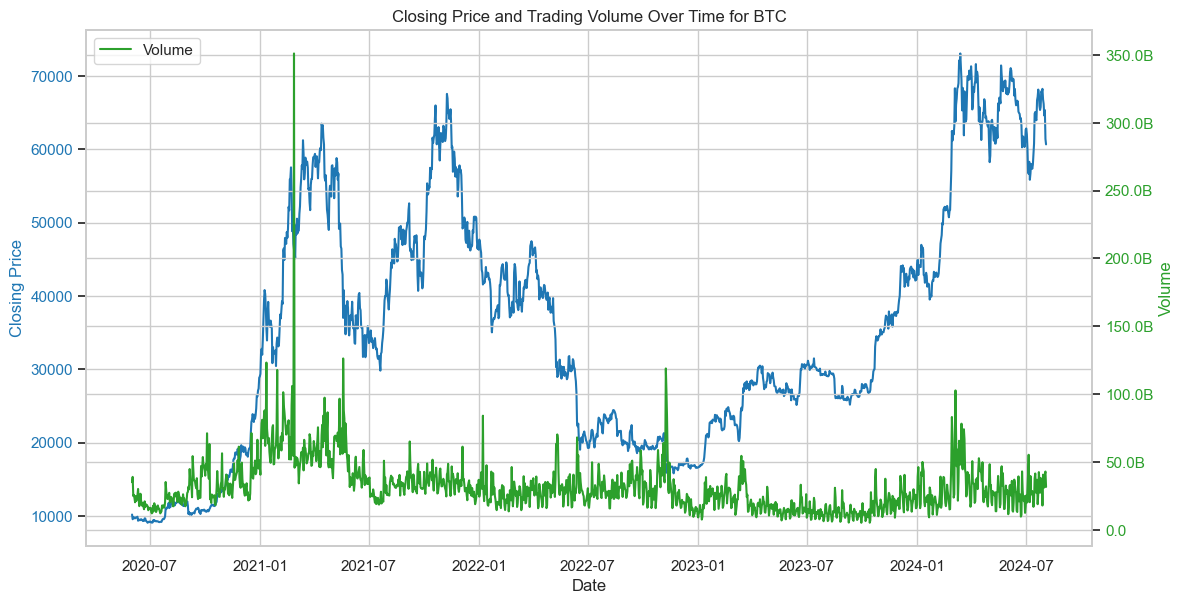

Summary statistics for ETH:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00  2071.985576  2127.585473  2011.091236   
min    2020-06-01 00:00:00   222.914490   228.598282   219.472672   
25%    2021-06-17 00:00:00  1382.684448  1445.151123  1329.763306   
50%    2022-07-03 00:00:00  1870.965088  1905.360474  1844.641724   
75%    2023-07-19 00:00:00  2945.560059  3026.415039  2864.735352   
max    2024-08-03 00:00:00  4810.071289  4891.704590  4718.039062   
std                    NaN  1070.767710  1099.908460  1036.484588   

             close        volume  
count  1525.000000  1.525000e+03  
mean   2073.489491  1.606395e+10  
min     222.959793  2.081626e+09  
25%    1387.932739  8.868955e+09  
50%    1871.792114  1.404577e+10  
75%    2945.892822  2.013103e+10  
max    4812.087402  8.448291e+10  
std    1069.475842  1.028848e+10  


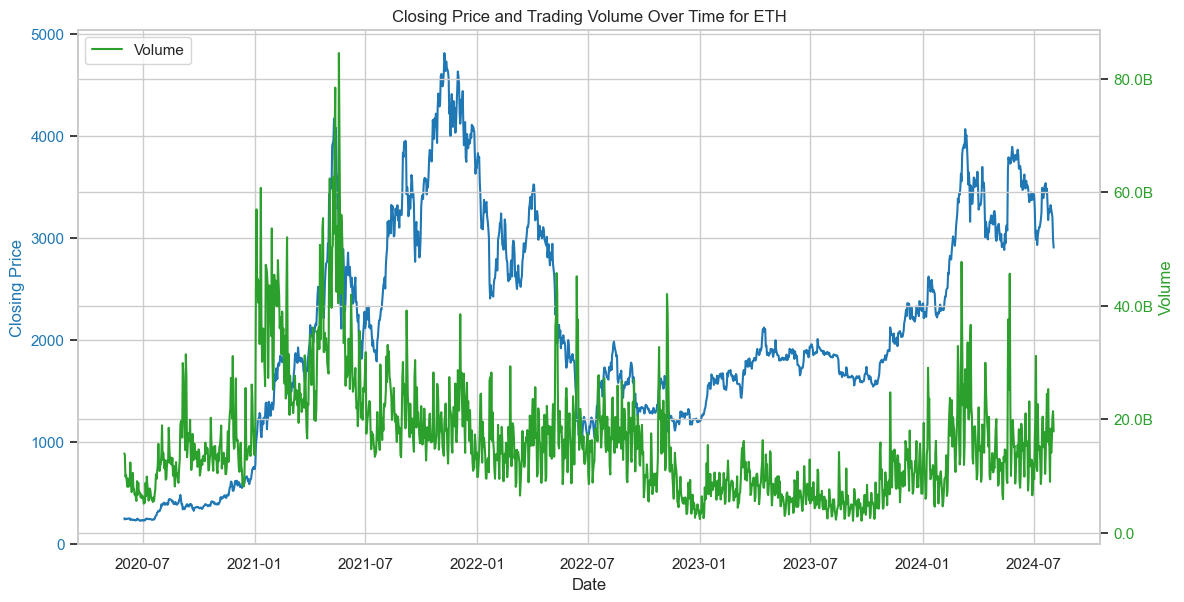

Summary statistics for SOL:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00    60.390068    62.974752    57.822590   
min    2020-06-01 00:00:00     0.564669     0.587839     0.547287   
25%    2021-06-17 00:00:00    17.149275    18.146622    16.236748   
50%    2022-07-03 00:00:00    32.461857    33.728569    31.186785   
75%    2023-07-19 00:00:00   100.407951   103.455795    96.103592   
max    2024-08-03 00:00:00   258.781555   260.062103   246.122421   
std                    NaN    61.366891    63.722952    58.766458   

             close        volume  
count  1525.000000  1.525000e+03  
mean     60.465631  1.401936e+09  
min       0.564669  6.520200e+05  
25%      17.257046  2.493649e+08  
50%      32.469395  8.547792e+08  
75%     100.440521  2.078536e+09  
max     258.934326  1.706864e+10  
std      61.349602  1.673747e+09  


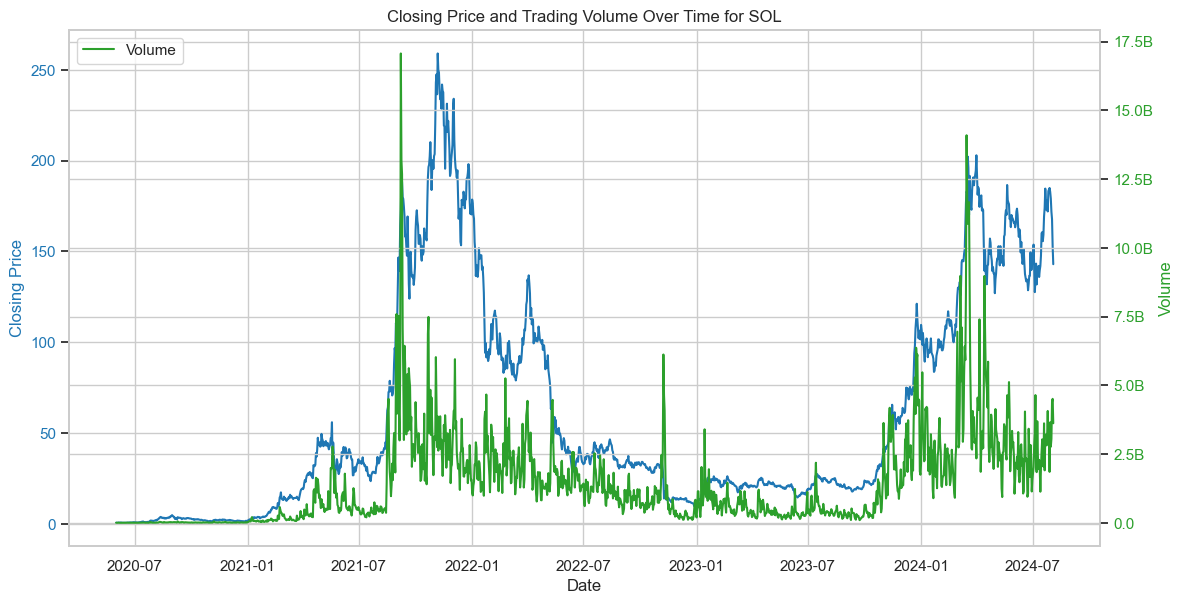

Summary statistics for ADA:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00     0.684051     0.709976     0.656644   
min    2020-06-01 00:00:00     0.074244     0.079173     0.069770   
25%    2021-06-17 00:00:00     0.306941     0.314248     0.298362   
50%    2022-07-03 00:00:00     0.447415     0.458502     0.435251   
75%    2023-07-19 00:00:00     0.997629     1.045075     0.935227   
max    2024-08-03 00:00:00     2.966390     3.099186     2.907606   
std                    NaN     0.594410     0.620659     0.566391   

             close        volume  
count  1525.000000  1.525000e+03  
mean      0.684269  1.485919e+09  
min       0.075360  5.825736e+07  
25%       0.307327  3.233043e+08  
50%       0.447353  6.446225e+08  
75%       0.997703  1.639201e+09  
max       2.968239  1.914198e+10  
std       0.594406  2.151544e+09  


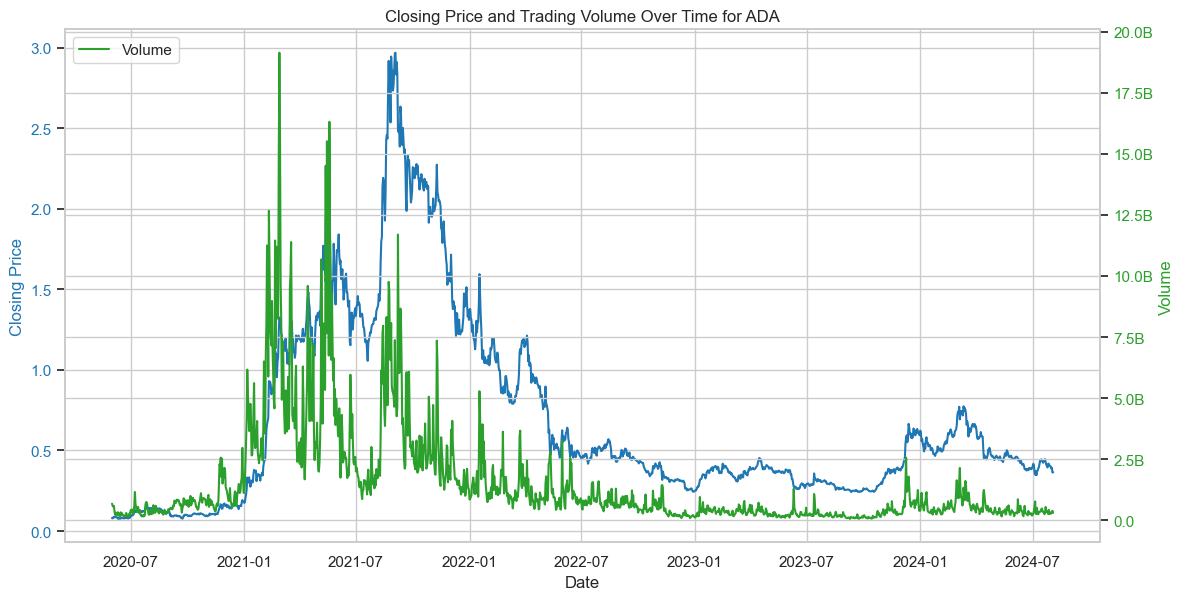

Summary statistics for BNB:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00   306.705295   314.969129   297.881964   
min    2020-06-01 00:00:00    15.185254    15.511128    15.020651   
25%    2021-06-17 00:00:00   231.263443   237.014221   226.150101   
50%    2022-07-03 00:00:00   302.034180   308.414368   293.600616   
75%    2023-07-19 00:00:00   405.399170   418.658600   394.661072   
max    2024-08-03 00:00:00   710.460388   720.672607   692.994751   
std                    NaN   170.277072   174.873010   164.971405   

             close        volume  
count  1525.000000  1.525000e+03  
mean    307.004626  1.473738e+09  
min      15.185254  1.365992e+08  
25%     231.574127  5.049875e+08  
50%     302.056274  1.087359e+09  
75%     406.632812  1.920237e+09  
max     710.464050  1.798295e+10  
std     170.142755  1.463055e+09  


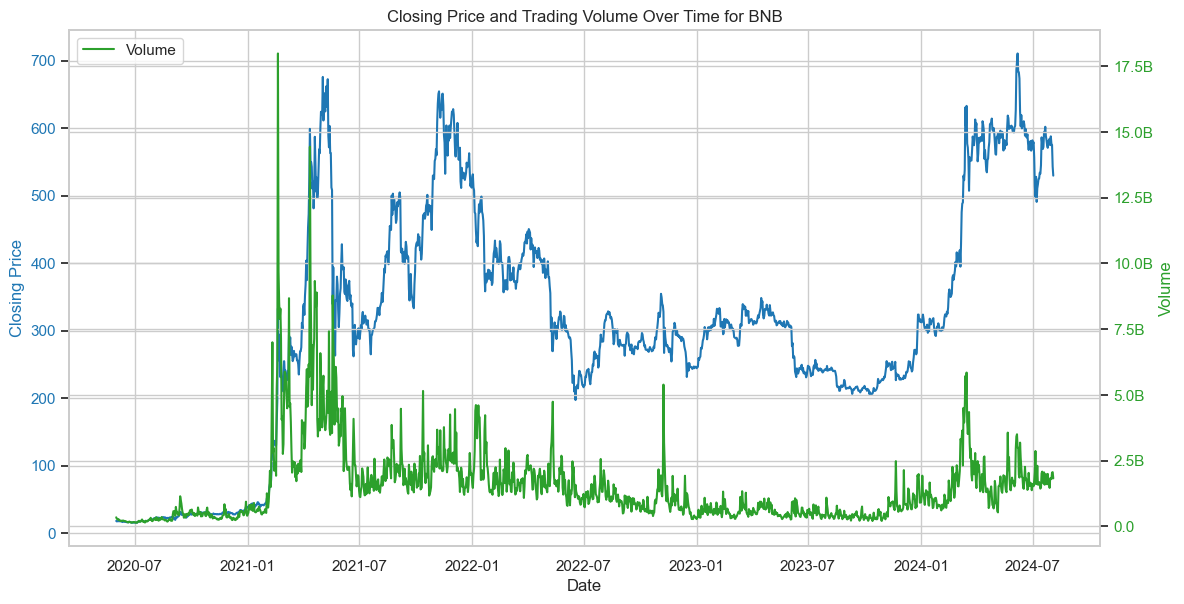

Summary statistics for XRP:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00     0.571156     0.591245     0.549411   
min    2020-06-01 00:00:00     0.175750     0.178338     0.174234   
25%    2021-06-17 00:00:00     0.382646     0.392260     0.373760   
50%    2022-07-03 00:00:00     0.514133     0.524818     0.501130   
75%    2023-07-19 00:00:00     0.655831     0.679923     0.627557   
max    2024-08-03 00:00:00     1.837281     1.964997     1.658103   
std                    NaN     0.275637     0.292382     0.257613   

             close        volume  
count  1525.000000  1.525000e+03  
mean      0.571381  2.951700e+09  
min       0.175870  2.253910e+08  
25%       0.382645  1.057710e+09  
50%       0.514741  1.652789e+09  
75%       0.656763  3.068579e+09  
max       1.839236  3.695518e+10  
std       0.275480  3.896638e+09  


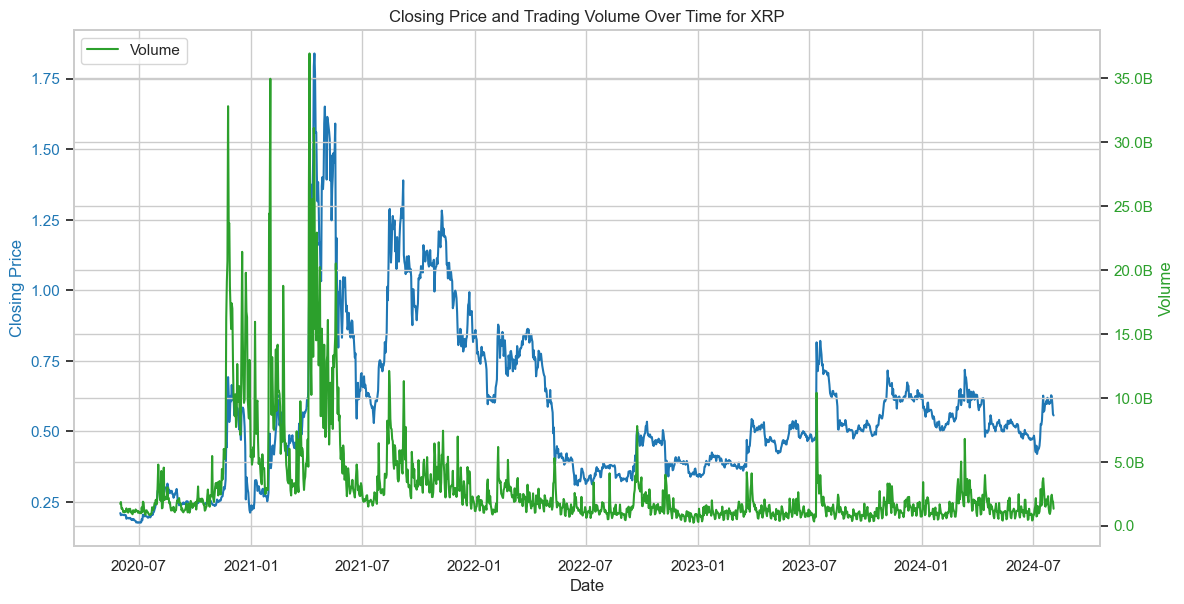

Summary statistics for OCEAN:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00     0.526343     0.554533     0.499419   
min    2020-06-01 00:00:00     0.067598     0.070651     0.066309   
25%    2021-06-17 00:00:00     0.315808     0.326767     0.306549   
50%    2022-07-03 00:00:00     0.434723     0.453769     0.416369   
75%    2023-07-19 00:00:00     0.673445     0.718144     0.625872   
max    2024-08-03 00:00:00     1.818558     1.941328     1.719507   
std                    NaN     0.336075     0.357429     0.316189   

             close        volume  
count  1525.000000  1.525000e+03  
mean      0.526591  3.684037e+07  
min       0.067598  6.259840e+05  
25%       0.315930  1.438292e+07  
50%       0.434848  2.556353e+07  
75%       0.671580  4.561371e+07  
max       1.817588  5.572306e+08  
std       0.336000  4.239516e+07  


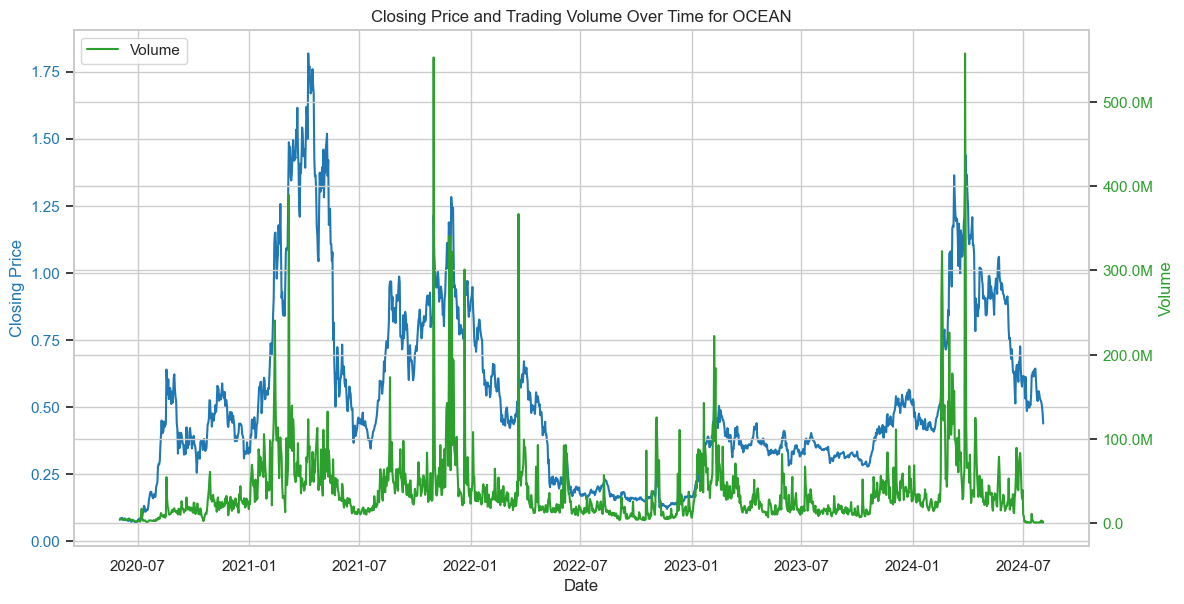

Summary statistics for NMR:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00    25.967525    27.390892    24.903559   
min    2020-06-01 00:00:00     7.784979     8.116864     7.199391   
25%    2021-06-17 00:00:00    15.217488    15.813085    14.760471   
50%    2022-07-03 00:00:00    23.371712    24.277685    22.368542   
75%    2023-07-19 00:00:00    32.608624    34.589973    31.226791   
max    2024-08-03 00:00:00    89.891556    96.137466    73.688042   
std                    NaN    13.109480    14.273015    12.261741   

             close        volume  
count  1525.000000  1.525000e+03  
mean     25.957852  1.772561e+07  
min       7.789050  2.647820e+05  
25%      15.208543  4.700608e+06  
50%      23.371304  9.269627e+06  
75%      32.602631  1.921597e+07  
max      90.790596  6.295865e+08  
std      13.112839  3.465593e+07  


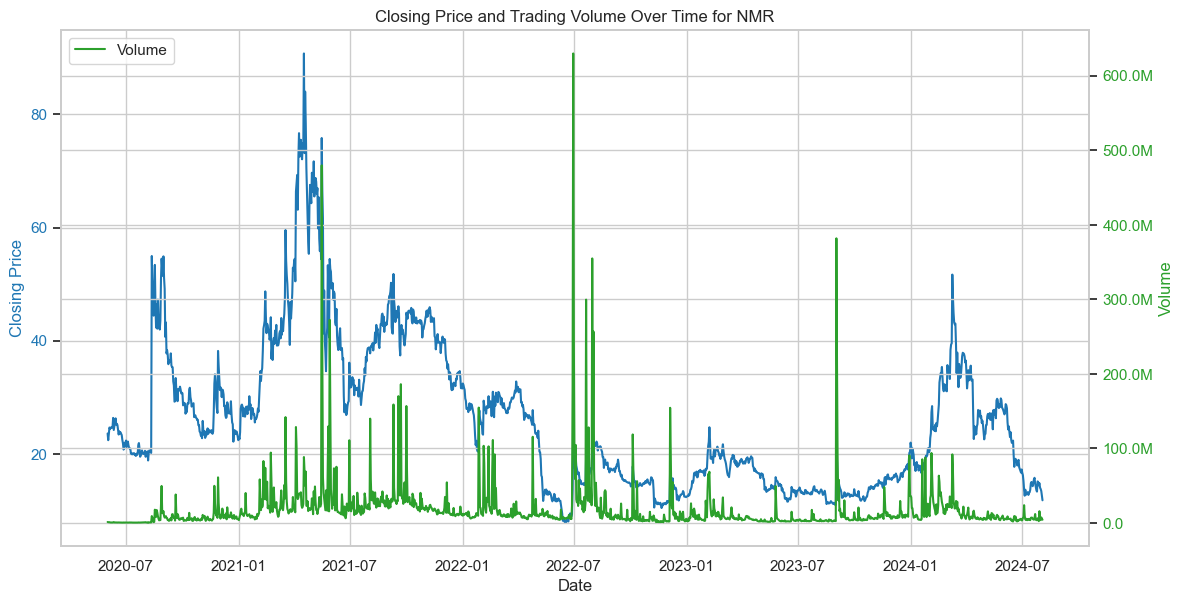

Summary statistics for FET:
                      date         open         high          low  \
count                 1525  1525.000000  1525.000000  1525.000000   
mean   2022-07-03 00:00:00     0.481339     0.509640     0.456259   
min    2020-06-01 00:00:00     0.022329     0.024353     0.022175   
25%    2021-06-17 00:00:00     0.094097     0.099807     0.089918   
50%    2022-07-03 00:00:00     0.284759     0.298746     0.265268   
75%    2023-07-19 00:00:00     0.563641     0.597089     0.539232   
max    2024-08-03 00:00:00     3.263083     3.474265     3.094668   
std                    NaN     0.591659     0.624941     0.560310   

             close        volume  
count  1525.000000  1.525000e+03  
mean      0.481985  6.912038e+07  
min       0.023014  1.821266e+06  
25%       0.094161  1.390010e+07  
50%       0.285277  3.237176e+07  
75%       0.566074  7.486428e+07  
max       3.263083  1.109447e+09  
std       0.591711  1.091914e+08  


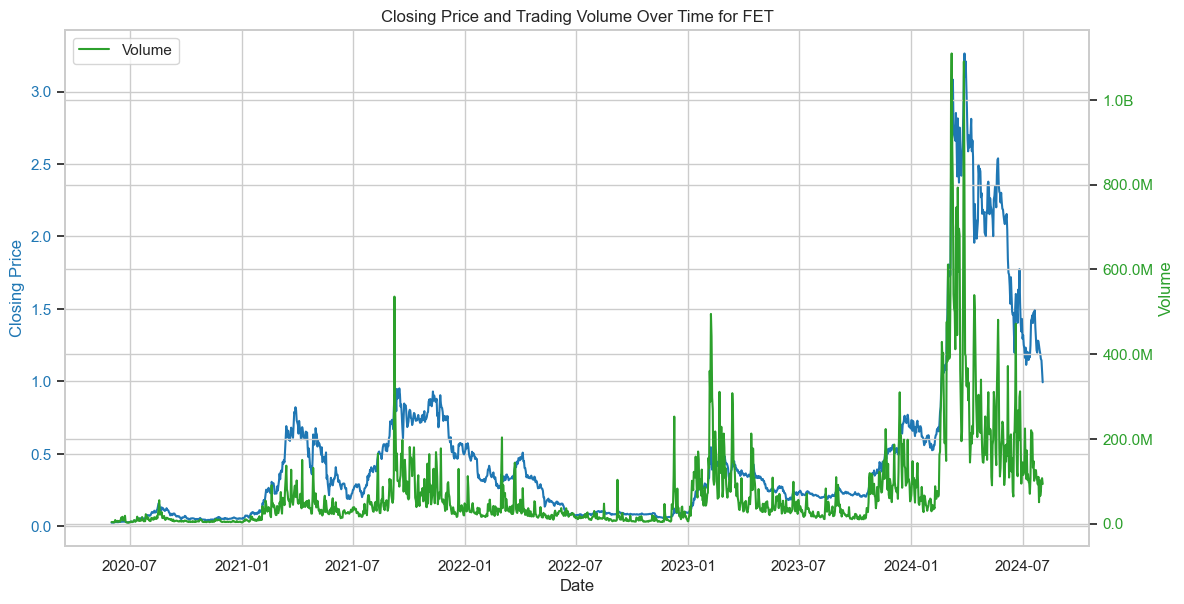

In [7]:
def perform_eda(df, symbol):
    df_symbol = df[df['symbol'] == symbol]
    
    # Summary statistics
    print(f"Summary statistics for {symbol}:")
    print(df_symbol.describe())
    
    # Plot closing price and volume on the same graph
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Closing Price', color=color)
    ax1.plot(df_symbol['date'], df_symbol['close'], color=color, label='Closing Price')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Volume', color=color)
    ax2.plot(df_symbol['date'], df_symbol['volume'], color=color, label='Volume')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter

    fig.tight_layout()  # Adjust the layout to make room for the y-labels
    plt.title(f'Closing Price and Trading Volume Over Time for {symbol}')
    plt.legend(loc='upper left')
    plt.show()


# Perform EDA for a sample of symbols 
sample_data = data[data['symbol'].isin(SAMPLE_SYMBOLS)]

for symbol in SAMPLE_SYMBOLS:
    df = data[data['symbol'] == symbol]
    perform_eda(df, symbol)
